In [211]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rahulk/car_5.jpg
/kaggle/input/rahulk/car_1.jpg
/kaggle/input/rahulk/car_7.jpg
/kaggle/input/rahulk/car_9.jpg
/kaggle/input/rahulk/car_2.jpg
/kaggle/input/rahulk/car_4.jpg
/kaggle/input/rahulk/car_3.jpg
/kaggle/input/rahulk/car_6.jpg
/kaggle/input/rahulk/car_10.jpg
/kaggle/input/rahulk/car_8.jpg


In [212]:
import cv2
import random
import matplotlib.pyplot as plt
import pytesseract
%matplotlib inline

In [213]:
# print(cv2.__version__)

# Reading the Image:->

In [214]:
image = cv2.imread('/kaggle/input/rahulk/car_6.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# We have converted the image to grayscale so that all the operations become faster as we have to not deal with multiple channels here..

In [215]:
def plot_images(img1, img2):
    fig = plt.figure(figsize=[20,20])
    ax1 = fig.add_subplot(121)     # one row two columns and targeting the first column
    ax1.imshow(img1)
    ax1.set(title="Normal Image")   # adding title

    ax2 = fig.add_subplot(122)    # one row two columns and targeting the second column
    ax2.imshow(img2, cmap='gray')
    ax2.set(title="Grayscale Image")  # adding title

# Plotting Image and Comparing:->

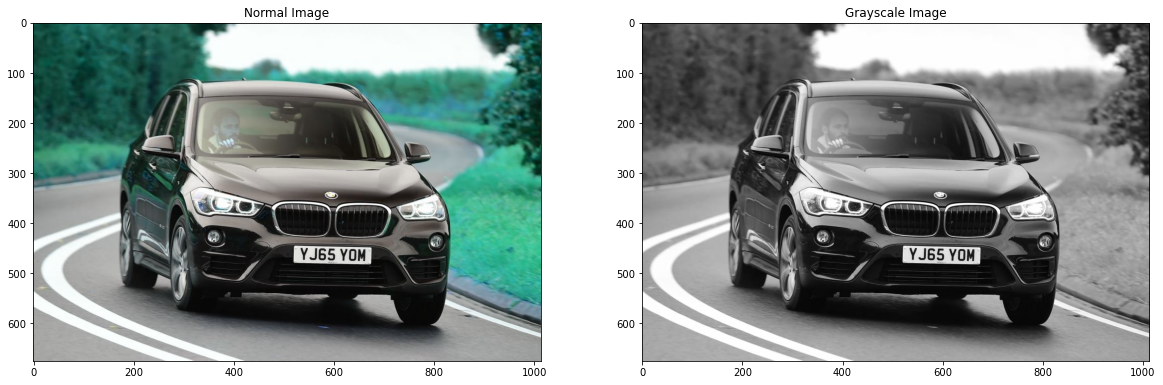

In [216]:
plot_images(image, gray)

# Fine both the images are successfully loaded.

# Here we are only interested in the number plate section and apart from that there are other things which are creating noise in the image. So we will blur the image so that most part of the image get blurred.

In [217]:
blur = cv2.bilateralFilter(gray, 10, 100, 100) # The 2nd parameter is used for blurring intensity..

In [218]:
def plot_images(img1, img2):
    fig = plt.figure(figsize=[20,20])
    ax1 = fig.add_subplot(121)     # one row two columns and targeting the first column
    ax1.imshow(img1,cmap='gray')
    ax1.set(title="Grayscale Image")   # adding title

    ax2 = fig.add_subplot(122)    # one row two columns and targeting the second column
    ax2.imshow(img2, cmap='gray')
    ax2.set(title="Grayscale Blurred Image")  # adding title

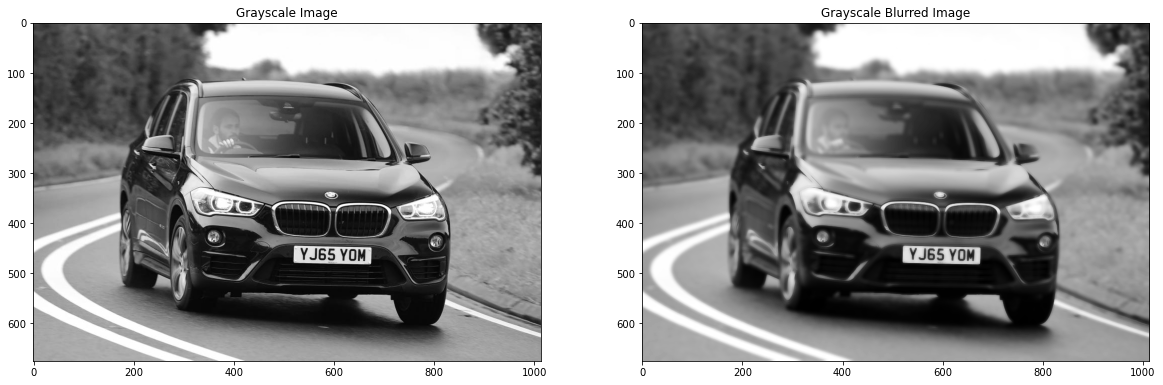

In [219]:
plot_images(gray, blur)

# After that also we are seeing our region of interest clearly.

# Now we will be doing edge detection. What it does is that it applies some filters horizontally and vertically and only reatin that image that only have the edges of the image..

In [220]:
edges = cv2.Canny(blur, 15, 100)

In [221]:
def plot_images(img1, img2):
    fig = plt.figure(figsize=[20,20])
    ax1 = fig.add_subplot(121)     # one row two columns and targeting the first column
    ax1.imshow(img1,cmap='gray')
    ax1.set(title="Grayscale Blurred Image")   # adding title

    ax2 = fig.add_subplot(122)     # one row two columns and targeting the second column
    ax2.imshow(img2, cmap='gray')
    ax2.set(title="Image with Edges")  # adding title

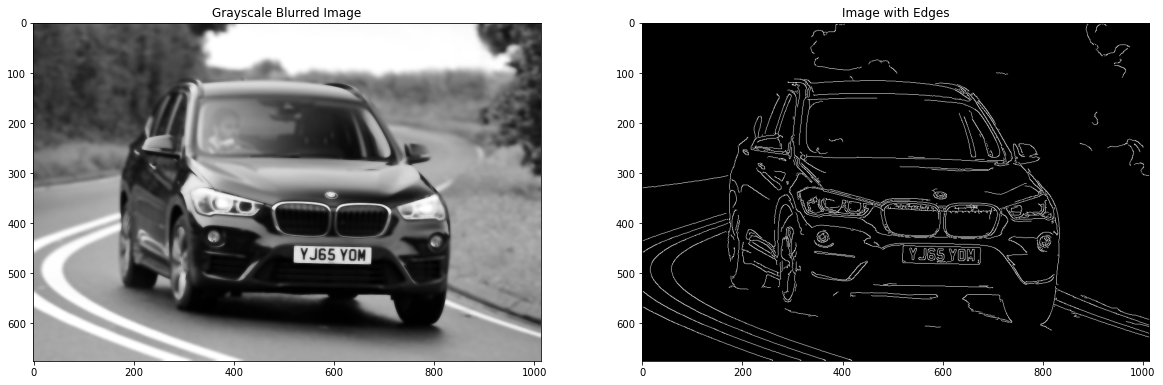

In [222]:
plot_images(blur, edges)

# So our image with only edges is ready..

# Now we need to find the contours in the image so that we will get the number plate section in the image..Any closed figure that has the same colour intensity will be returned by the findcontours function. They return x, y coordinates that hava a boundary..

In [223]:
counters, new = cv2.findContours(edges.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE) #See, there are three arguments in cv.findContours() function, first one is source image, second is contour retrieval mode, third is contour approximation method.

In [224]:
# print(cnts)
# print(new)

In [225]:
image_copy = image.copy()

In [226]:
_ = cv2.drawContours(image_copy, counters, -1, (255,0,255),2)

In [227]:
def plot_images(img1, img2):
    fig = plt.figure(figsize=[20,20])
    ax1 = fig.add_subplot(121)     # one row two columns and targeting the first column
    ax1.imshow(img1,cmap='gray')
    ax1.set(title="Grayscale Blurred Image")   # adding title

    ax2 = fig.add_subplot(122)     # one row two columns and targeting the second column
    ax2.imshow(img2, cmap='gray')
    ax2.set(title="Image with Contours")      # adding title

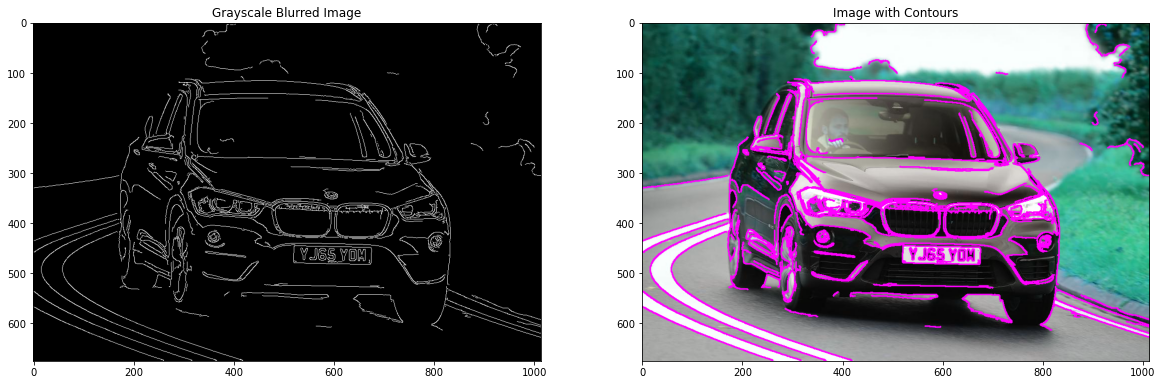

In [228]:
plot_images(edges, image_copy)

# Now we have a lot of contours..

In [229]:
print(len(counters))

459


# So in total we have 459 contours.. Out of these 459 contours we have 1 as our number plate..

# Most of the number plates are rectangle in shape..
# There width to height ratio turns out to be very big than other contours..

# Calculating the area of the contours and we reverse it. Selecting first 30 max area contours. With this we are ignoring all small contours.

In [230]:
counters_new = sorted(counters, key=cv2.contourArea, reverse=True)[:20] 

In [231]:
image_copy = image.copy()
_ = cv2.drawContours(image_copy, counters_new, -1, (255,0,255),2)

In [232]:
def plot_images(img1, img2):
    fig = plt.figure(figsize=[20,20])
    ax1 = fig.add_subplot(121)     # one row two columns and targeting the first column
    ax1.imshow(img1,cmap='gray')
    ax1.set(title="Grayscale Image")   # adding title

    ax2 = fig.add_subplot(122)     # one row two columns and targeting the second column
    ax2.imshow(img2, cmap='gray')
    ax2.set(title="Image with top 20 Contours")      # adding title

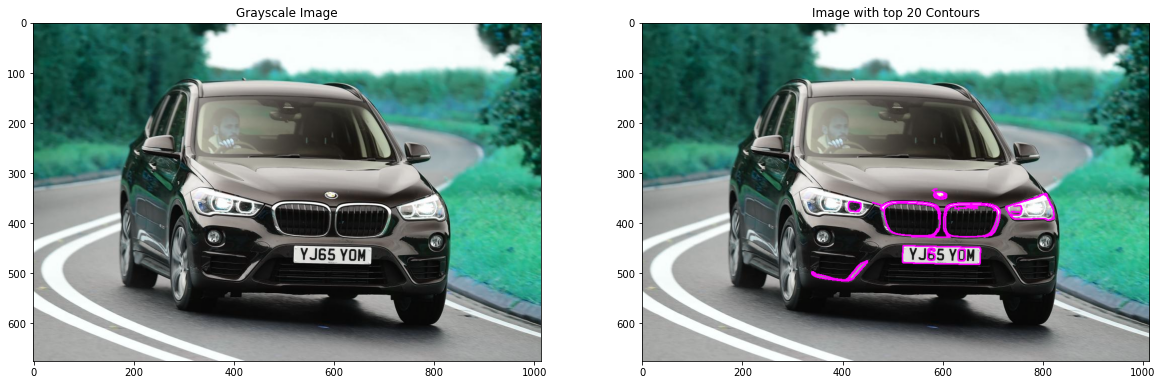

In [233]:
plot_images(image, image_copy)

# So we are seeing here that all the small contours are ignored..

In [234]:
plate = None

for counter in counters_new:
    perimeter = cv2.arcLength(counter, True)
    edges_count = cv2.approxPolyDP(counter, 0.02 * perimeter, True) # helps in counting the number of edges in an image
    if len(edges_count) == 4:
        x,y,w,h = cv2.boundingRect(counter)
        plate = image[y:y+h, x:x+w]
        break

cv2.imwrite("plate.png", plate)

True

In [235]:
def plot_images(img1):
    fig = plt.figure(figsize=[10,10])
    ax1 = fig.add_subplot(111)     # one row two columns and targeting the first column
    ax1.imshow(img1,cmap='gray')
    ax1.set(title="Plate Image")   # adding title  

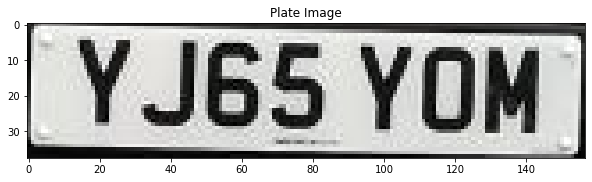

In [236]:
plot_images(plate)

In [237]:
car_number = pytesseract.image_to_string(plate, lang="eng")

In [238]:
print(car_number)

YJ65 YOM


# Decoded the number on the number plate..

# But sometimes this model fails as beacause of the image angle picture brightness etc etc...